In [52]:
import pandas as pd
import geopandas as gpd
import numpy as np
import fiona
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [31]:
covid_hist = pd.read_csv('covid_df.csv', index_col=0)

covid_hist.head()

,Category,Variable,3/26/2020,3/27/2020
0,NaN,Total,23112,25573
1,NaN,Median Age (Range),47,47
2,Age Group,0 to 17,495,524
3,Age Group,18 to 44,10145,11202
4,Age Group,45 to 64,7869,8745


In [64]:
url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON"
boroughs_wgs84 = gpd.read_file(url)
boroughs = boroughs_wgs84.to_crs({'init': 'epsg:2263'})

boroughs.crs

{'init': 'epsg:2263'}

In [65]:
covid_geo = covid_hist.loc[covid_hist['Category'] == "Borough"]
covid_geo = covid_geo.drop(columns="Category")
boroughs = boroughs.rename(columns={'boro_name': 'Borough'})
covid_geo = boroughs.join(covid_geo.set_index('Variable'), on='Borough')

covid_geo

,boro_code,Borough,shape_area,shape_leng,geometry,3/26/2020,3/27/2020
0,2,Bronx,1186612478.27,462958.187578,"MULTIPOLYGON (((1012821.806 229228.265, 101278...",4243,4655
1,5,Staten Island,1623757282.78,325956.009,"MULTIPOLYGON (((970217.022 145643.332, 970227....",1330,1440
2,3,Brooklyn,1937593022.64,738745.842115,"MULTIPOLYGON (((1021176.479 151374.797, 102100...",6095,6750
3,4,Queens,3045878293.21,904188.424488,"MULTIPOLYGON (((1029606.077 156073.814, 102957...",7362,8214
4,1,Manhattan,636602658.887,361212.476098,"MULTIPOLYGON (((981219.056 188655.316, 980940....",4046,4478


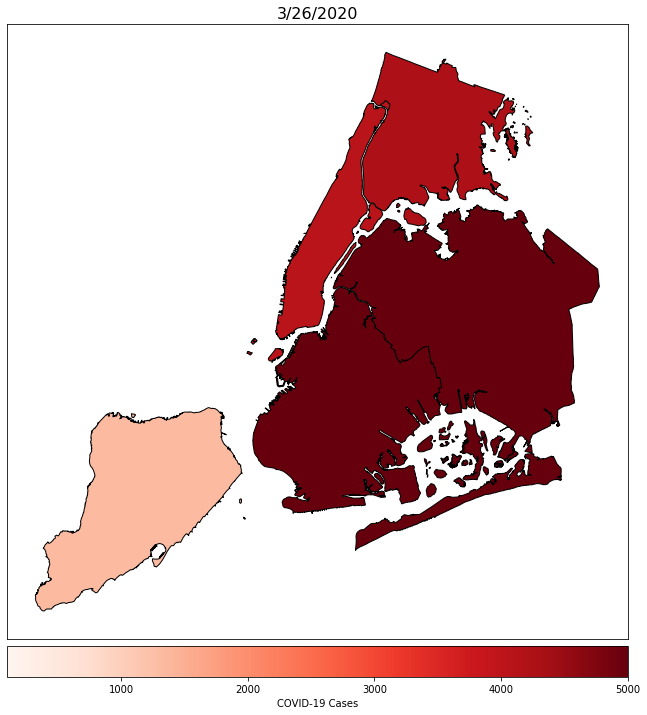

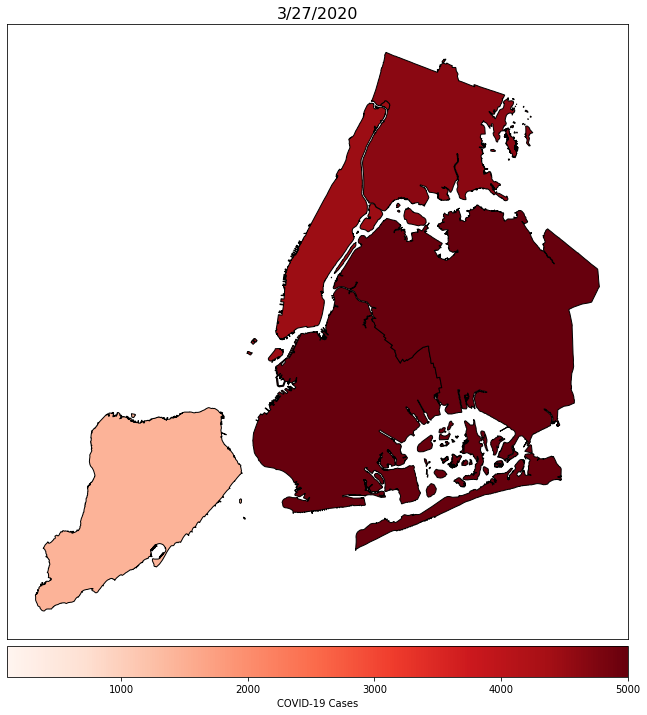

In [72]:
for date in covid_geo.columns[5:]:
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.title(date, size='16')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.1)
    covid_geo.plot(ax=ax, column=date, cmap='Reds', edgecolor='black',
               legend=True, cax = cax, vmin=100, vmax=5000,
               legend_kwds={'label': 'COVID-19 Cases', 
                                         'orientation': 'horizontal'})
    ax.tick_params(left=0, labelleft=0, bottom=0, labelbottom=0)

plt.show()